# Quantification of a plasmid’s concentration range

The script assesses the optimal concentration range for an arbitrary plasmid in a cell-free expression system. The estimation is conducted by exploiting **Michaelis-Menten approach**. It allso points out a unique kinetic property of plasmid that is independent of its initial concentration in a bulk. 


In [1]:
#!/usr/bin/python

import numpy as np
import matplotlib.pyplot as plt
from pandas import *
import scipy.optimize

from statsmodels.formula.api import ols

## Kinetic curves plotting
Firstly, it plots the kinetic curves of a cell-free gene expression, labeling each concentration of used plasmids. The depiction is straightforward: *time* versus the GFP fluorescent *signal*. 

/usr/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


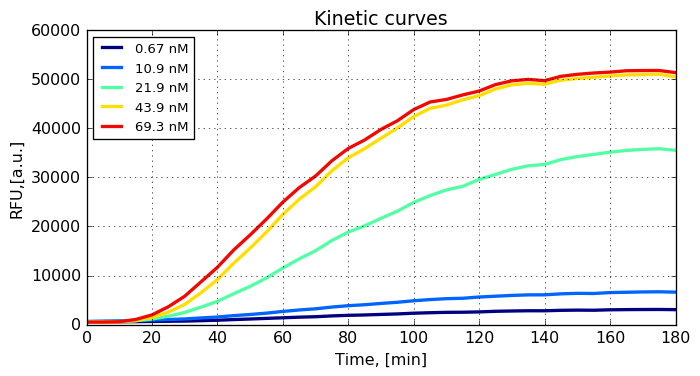

In [2]:
plt.rc('font', size=12)
fig = plt.figure(num=None, figsize=(8, 4), dpi=95)

t, a1, a2, a3, a4, a5 = np.loadtxt("kin.csv", skiprows=1, unpack=True)

n=2.5
num_plots = 5
colormap = plt.cm.jet
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

ax1 = fig.add_subplot(111)
ax1.set_ylabel('RFU,[a.u.]')
ax1.set_xlabel('Time, [min]')
ax1.set_title('Kinetic curves')

ax1.plot(t/60, a1, label='0.67 nM', lw=n)
ax1.plot(t/60, a2, label='10.9 nM', lw=n)
ax1.plot(t/60, a3, label='21.9 nM', lw=n)
ax1.plot(t/60, a4, label='43.9 nM', lw=n)
ax1.plot(t/60, a5, label='69.3 nM', lw=n)

plt.legend(loc='upper left', frameon=True, fontsize=10)
plt.grid(True)

## Saturation curves

This part shows the correlation between the concentration of a plasmid in a bulk reaction and its end-point GFP production. Ideally it should follow the hyperbolic law of saturation. That is Michaelis-Menten law:

$$\omega = \frac{\omega_{max}[CP]}{K_M + [CP]}$$

The input file must be a table of concetration mean values and its end-points with corresponding stdv, so that the error bars can be indicated.

In [3]:
SaturationData = pandas.read_table('saturation.csv', decimal=".",skiprows=2, sep='\s+')
print(SaturationData)

    conc     s1     s2     s3  meanS        stdvS
0   1.12   3049   3139   3463   3217   217.742968
1   2.81   6617   7596   6787   7000   523.103240
2  11.64  35529  37060  41935  38174  3345.305716
3  31.36  50463  49332  48987  49594   772.092611
4  44.40  51344  50391  50437  50724   537.428135


<Container object of 3 artists>

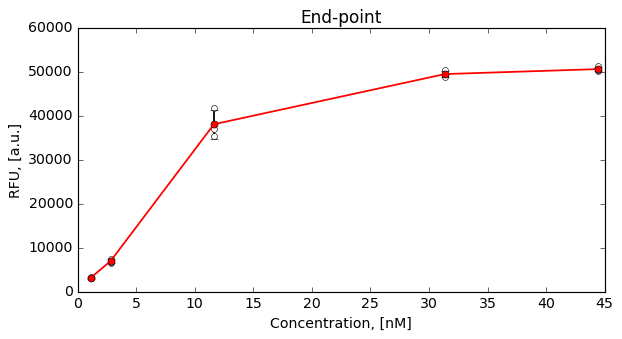

In [4]:
plt.rc('font', size=12)
fig = plt.figure(num=None, figsize=(8, 4), dpi=85)

c, y1, y2, y3, my, dy = np.loadtxt("saturation.csv", skiprows=3, unpack=True)

n=1.5
n1=5

ax2 = fig.add_subplot(111)
ax2.set_ylabel('RFU, [a.u.]')
ax2.set_xlabel('Concentration, [nM]')
ax2.set_title('End-point')

#plot all points as holes
ax2.plot(c,y1,'o',mfc='white',ms=n1)
ax2.plot(c,y2,'o',mfc='white',ms=n1)
ax2.plot(c,y3,'o',mfc='white',ms=n1)

ax2.errorbar(c, my, yerr=dy, fmt='-or', ecolor='black',lw=n)


## Ordinary least squares regression and the $\chi^2$-criterion
In order to obtain the estimation of both the saturation concentration and the efficiency of gene expression, we exploit a conventional approach of the Michaelis-Menten **double reciprocal plot**. In other words, decomposition of the hyperbolic curve inro a linear one and further linear regression.
$$\frac{1}{\omega}= \frac{1}{\omega_m}+\frac{K_M}{\omega_M}\frac{1}{[S]_o}$$

Here OLS model is used and also, in order to asses the contribution of stdv value the $\chi^2$ criterion

Fitting parameters chi** criteria: K, B
[  2.62126268e-04   1.31551048e-05]
Parameters estimation:
Chi^2................. 23.03
KM.................... 19.93
KM-error.............. 6.48
Wmax.................. 76016.12
Wmax-error............ 0.16
R^2................... 1.00
KM.................... 38.99
KM-error.............. 26.72
Wmax.................. 113468.76
Wmax-error............ 0.68


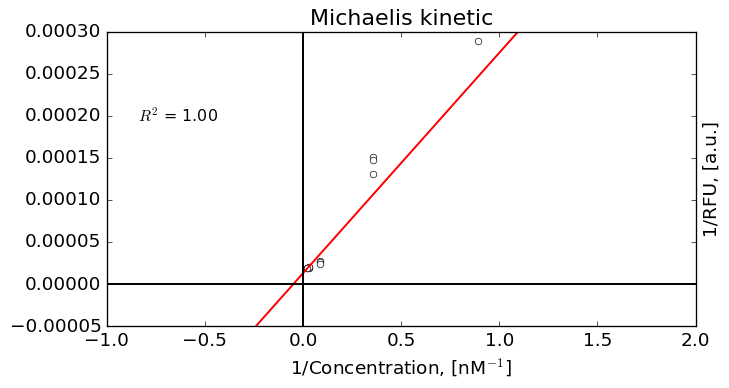

In [8]:
plt.rc('font', size=14)
fig = plt.figure(num=None, figsize=(8, 4), dpi=95)

ax3 = fig.add_subplot(111)
ax3.set_ylabel('1/RFU, [a.u.]')
ax3.set_xlabel('1/Concentration, [nM$^{-1}$]')
ax3.set_title('Michaelis kinetic')
ax3.yaxis.set_label_position("right")

ax3.set_xlim(-1,2)
ax3.set_ylim(-0.00005,.0003)

ax3.plot(1/c,1/y1,'o',mfc='white',ms=n1)
ax3.plot(1/c,1/y2,'o',mfc='white',ms=n1)
ax3.plot(1/c,1/y3,'o',mfc='white',ms=n1)

#inear regression 1/cn --- 1/F via chi-squared
def fun(t,k,b):
    return (t*k+b)
  
c0, y10, y20, y30, my0, dy0 = np.loadtxt("michaelis.csv", skiprows=3, unpack=True)

# initial guesses for fitting parameters
k0 = 0.1
b0 = 0.1
# fit data using SciPy's Levenberg-Marquart method
nlfit, nlpcov = scipy.optimize.curve_fit(fun,
                c0, my0, p0=[k0,b0], sigma=dy0)
# unpack fitting parameters
k, b = nlfit

print 'Fitting parameters chi** criteria: K, B'
print nlfit
# unpack uncertainties in fitting parameters from diagonal of covariance matrix
dk, db = \
          [np.sqrt(nlpcov[j,j]) for j in range(nlfit.size)]

# create fitting function from fitted parameters
x_fit = np.linspace(-2.0,1.8, 100)
y_fit = fun(x_fit, k, b)
# Calculate residuals and reduced chi squared
resids = my0 - fun(c0, k, b)
redchisqr = ((resids/dy0)**2).sum()/float(c0.size-2)

#************text out***************************************
ax3.plot(x_fit,y_fit,'r-',mfc='white',lw=n)

#********************simple linear regression***************
data = DataFrame({'x': c0, 'y': my0})
model = ols("y ~ x", data).fit()

ax3.text(0.1, 0.85, '$R^2$ = {0:0.2f}'
         .format(model.rsquared),transform = ax2.transAxes,fontsize=12)

ax3.axhline(0, color='black',lw=n)
ax3.axvline(0, color='black',lw=n)

#********************PRINT OUT************************************
print 'Parameters estimation:'
print 'Chi^2................. {0:0.2f}'.format(redchisqr)
print 'KM.................... {0:0.2f}'.format(k/b)#error propagation
print 'KM-error.............. {0:0.2f}'.format(np.sqrt(b**-2*dk**2+k**2*b**-4*db**2))
print 'Wmax.................. {0:0.2f}'.format(1/b)
print 'Wmax-error............ {0:0.2f}'.format(db/b)
print '======================'
print 'R^2................... {0:0.2f}'.format(model.rsquared)
print 'KM.................... {0:0.2f}'.format(model.params[1]/model.params[0])
print 'KM-error.............. {0:0.2f}'.format(np.sqrt(model.params[0]**-2*model.bse[1]**2+
					       model.params[1]**2*model.params[0]**-4*model.bse[0]**2))
print 'Wmax.................. {0:0.2f}'.format(1/model.params[0])
print 'Wmax-error............ {0:0.2f}'.format(model.bse[0]/model.params[0])

